# GNN模型预测版图寄生电容

## Debug 设置

In [1]:
import faulthandler


faulthandler.enable()

## 参数解析

In [2]:
import sys
import argparse
from config import *


sys.argv = ['run.py']

def str2bool(v):
	if v.lower() in ('yes', 'true', 't', 'y', '1'):
		return True
	elif v.lower() in ('no', 'false', 'f', 'n', '0'):
		return False
	else:
		raise argparse.ArgumentTypeError('Boolean value expected.')

parser = argparse.ArgumentParser()
parser.add_argument('--dir_prj', type=str, default=dir_prj,
										help='project directory')
parser.add_argument('--seed', type=int, default=seed,
										help='random seed')
parser.add_argument('--pattern_nums', type=int, nargs='+', default=pattern_nums,
										help='pattern nums')
parser.add_argument('--thresh', type=int, nargs='+', default=thresh,
										help='threshold')
parser.add_argument('--num_process', type=int, default=num_process,
										help='multiprocessing number')
parser.add_argument('--model_name', type=str, default=model_name,
										help='model name [gcn, graph_sage, gat]')
parser.add_argument('--lr', type=float, default=lr,
										help='adam learning rate')
parser.add_argument('--batch_size', type=int, default=batch_size,
										help='batch size')
parser.add_argument('--epochs', type=int, default=epochs,
										help='number of epochs')
parser.add_argument('--load_params', type=str2bool, default=LOAD_PARAMS,
										help='load parameters')
parser.add_argument('--set_memory_growth', type=str2bool, default=SET_MEMORY_GROWTH,
										help='set memory growth')
parser.add_argument('--set_memory_limit', type=int, default=SET_MEMORY_LIMIT,
										help='memory limit, -1 for no limit')
parser.add_argument('--set_multi_gpu_num', type=int, default=SET_MULTI_GPU_NUM,
										help='set multi gpu numbers')


args = parser.parse_args()
dir_prj = args.dir_prj
seed = args.seed
pattern_nums = args.pattern_nums
thresh = args.thresh
num_process = args.num_process
model_name = args.model_name
lr = args.lr
batch_size = args.batch_size
epochs = args.epochs
LOAD_PARAMS = args.load_params
SET_MEMORY_GROWTH = args.set_memory_growth
SET_MEMORY_LIMIT = args.set_memory_limit
SET_MULTI_GPU_NUM = args.set_multi_gpu_num
SET_MULTI_GPU_NUM = min(SET_MULTI_GPU_NUM, 4)

## log 设置

In [3]:
import logging


console_handler = logging.StreamHandler()
file_handler = logging.FileHandler(f'../logs/{model_name}_lr{lr}_epochs{epochs}.log', mode='w', encoding='utf-8')

# 设置日志格式
logging.basicConfig(
    format="%(asctime)s %(filename)s [line:%(lineno)d] %(levelname)s %(message)s",
    datefmt='%Y-%m-%d %H:%M:%S',
    handlers=[console_handler, file_handler],
    level=logging.INFO
)

# loging args
logging.info('------------------------args start----------------------------')
for k, v in vars(args).items():
		logging.info(f'{k} = {v}')
logging.info('-------------------------args end-----------------------------')

2025-04-04 13:54:25 974645172.py [line:16] INFO ------------------------args start----------------------------
2025-04-04 13:54:25 974645172.py [line:18] INFO dir_prj = D:/learn_more_from_life/computer/EDA/work/prj/rc_predict/
2025-04-04 13:54:25 974645172.py [line:18] INFO seed = 42
2025-04-04 13:54:25 974645172.py [line:18] INFO pattern_nums = [4]
2025-04-04 13:54:25 974645172.py [line:18] INFO thresh = [0, 3000]
2025-04-04 13:54:25 974645172.py [line:18] INFO num_process = 8
2025-04-04 13:54:25 974645172.py [line:18] INFO model_name = gcn
2025-04-04 13:54:25 974645172.py [line:18] INFO lr = 0.001
2025-04-04 13:54:25 974645172.py [line:18] INFO batch_size = 8
2025-04-04 13:54:25 974645172.py [line:18] INFO epochs = 3
2025-04-04 13:54:25 974645172.py [line:18] INFO load_params = False
2025-04-04 13:54:25 974645172.py [line:18] INFO set_memory_growth = True
2025-04-04 13:54:25 974645172.py [line:18] INFO set_memory_limit = -1
2025-04-04 13:54:25 974645172.py [line:18] INFO set_multi_gp

## tensorflow框架设置

### 多卡设置

In [4]:
import os


gpus = ''
for i in range(SET_MULTI_GPU_NUM):
	if i == 0:
		gpus += str(i)
	else:
		gpus += ',' + str(i)

os.environ['CUDA_VISIBLE_DEVICES'] = gpus

### log level 设置

In [ ]:
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  

### 显存限制

In [5]:
import tensorflow as tf


# 方法一 set memory growth
if SET_MEMORY_GROWTH:
	gpus = tf.config.experimental.list_physical_devices('GPU')
	if len(gpus) > 0:
		try:
			logging.info(gpus[:SET_MULTI_GPU_NUM])
			for gpu in gpus[:SET_MULTI_GPU_NUM]:
				tf.config.experimental.set_memory_growth(gpu, True)
		except RuntimeError as e:
			logging.error(e)

# 方法二 set memory limit
if SET_MEMORY_LIMIT > 0:
	gpus = tf.config.experimental.list_physical_devices('GPU')
	if len(gpus) > 0:
		try:
			logging.info(gpus[:SET_MULTI_GPU_NUM])
			for gpu in gpus[:SET_MULTI_GPU_NUM]:
				tf.config.experimental.set_virtual_device_configuration(
					gpu,
					[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=SET_MEMORY_LIMIT)])
			logging.info(f'set memory limit to {SET_MEMORY_LIMIT}MB')
		except RuntimeError as e:
			logging.error(e)

2025-04-04 13:54:30 4023682399.py [line:9] INFO [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 基本库导入

In [6]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# 自定义模块导入
from data.dataset import MyDataset
from models.gcn import GCN
from models.graph_sage import GraphSage
from models.gat import GAT

# fix seed
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## 数据导入与数据清洗

In [7]:
# load data
logging.info('---------------------loading total data-----------------------')
dataset_total = MyDataset(dir_prj=dir_prj,
							pattern_nums=pattern_nums,
						  x_name='x_total.npy',
						  y_name='y_total.npy',
						  g_name='total',
						  num_process=num_process,
						  update=False)
logging.info('---------------------load total data done---------------------')

logging.info('---------------------loading couple data----------------------')
dataset_couple = MyDataset(dir_prj=dir_prj,
								pattern_nums=pattern_nums,
						   x_name='x_couple.npy',
						   y_name='y_couple.npy',
						   g_name='couple',
						   num_process=num_process,
						   update=False)
logging.info('---------------------load couple data done--------------------')

# clean data
logging.info('------------------------before cleaning-----------------------')
logging.info(f'dataset total: {dataset_total}')
logging.info(f'dataset couple: {dataset_couple}')
logging.info('------------------------after cleaning------------------------')
dataset_total.filter(lambda g: thresh[0] <= g.n_nodes <= thresh[1])
dataset_couple.filter(lambda g: thresh[0] <= g.n_nodes <= thresh[1])
logging.info(f'dataset total: {dataset_total}')
logging.info(f'dataset couple: {dataset_couple}')


2025-04-04 13:54:32 1614378019.py [line:2] INFO ---------------------loading total data-----------------------


pattern4 data downloaded
all data downloaded
reading pattern4


2025-04-04 13:54:33 1614378019.py [line:10] INFO ---------------------load total data done---------------------
2025-04-04 13:54:33 1614378019.py [line:12] INFO ---------------------loading couple data----------------------


pattern4 graph path D:/learn_more_from_life/computer/EDA/work/prj/rc_predict/data/graph_data/pattern4\total_300.npz not exist
pattern4 data readed
all data readed
pattern4 data downloaded
all data downloaded
reading pattern4


2025-04-04 13:54:33 1614378019.py [line:20] INFO ---------------------load couple data done--------------------
2025-04-04 13:54:33 1614378019.py [line:23] INFO ------------------------before cleaning-----------------------
2025-04-04 13:54:33 1614378019.py [line:24] INFO dataset total: MyDataset(n_graphs=300)
2025-04-04 13:54:33 1614378019.py [line:25] INFO dataset couple: MyDataset(n_graphs=300)
2025-04-04 13:54:33 1614378019.py [line:26] INFO ------------------------after cleaning------------------------
2025-04-04 13:54:33 1614378019.py [line:29] INFO dataset total: MyDataset(n_graphs=300)
2025-04-04 13:54:33 1614378019.py [line:30] INFO dataset couple: MyDataset(n_graphs=300)


pattern4 graph path D:/learn_more_from_life/computer/EDA/work/prj/rc_predict/data/graph_data/pattern4\couple_300.npz not exist
pattern4 data readed
all data readed


## 数据分割

In [8]:
# split data # 6:2:2
np.random.shuffle(dataset_total)
np.random.shuffle(dataset_couple)
n = len(dataset_total)
train_data_total, valid_data_total, test_data_total = dataset_total[0:int(n*0.6)], \
													  dataset_total[int(n*0.6):int(n*0.8)], \
													  dataset_total[int(n*0.8):]
n = len(dataset_couple)
train_data_couple, valid_data_couple, test_data_couple = dataset_couple[0:int(n * 0.6)], \
														 dataset_couple[int(n * 0.6):int(n * 0.8)], \
														 dataset_couple[int(n * 0.8):]


C:\Users\19596\AppData\Local\Temp\ipykernel_33692\4135933038.py:2: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(dataset_total)
C:\Users\19596\AppData\Local\Temp\ipykernel_33692\4135933038.py:3: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(dataset_couple)


## 模型构建

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_squared_error
from spektral.data import BatchLoader
from utils.model import huber_loss, mse_mrse_loss, measure_ratio_good


# loss and weighted metrics
loss_func = mse_mrse_loss
weighted_metrics = [measure_ratio_good]

# set multi gpu
if SET_MULTI_GPU_NUM > 1:
	devices = [f'/gpu:{i}' for i in range(SET_MULTI_GPU_NUM)]
	mirror_strategy = tf.distribute.MirroredStrategy(devices=devices)
	with mirror_strategy.scope():
		logging.info('---------------------set multi gpu done---------------------')
		logging.info(f'num devices: {mirror_strategy.num_replicas_in_sync}')
		logging.info(f'devices: {devices}')
		logging.info('------------------------------------------------------------')
		# GCN model
		if model_name == 'gcn':
			model_total = GCN()
			model_couple = GCN()
			model_best_total = GCN()
			model_best_couple = GCN()
			logging.info('buld model gcn done')
		elif model_name == 'graph_sage':
			model_total = GraphSage()
			model_couple = GraphSage()
			model_best_total = GraphSage()
			model_best_couple = GraphSage()
			logging.info('buld model graph_sage done')
		elif model_name == 'gat':
			model_total = GAT()
			model_couple = GAT()
			model_best_total = GAT()
			model_best_couple = GAT()
			logging.info('buld model gat done')
		else:
			logging.error('model_name error')
			raise ValueError('model_name error')
		model_total.compile(optimizer=Adam(learning_rate=lr, epsilon=epsilon),
												loss=loss_func,
												weighted_metrics=weighted_metrics)
		model_couple.compile(optimizer=Adam(learning_rate=lr, epsilon=epsilon),
												loss=loss_func,
												weighted_metrics=weighted_metrics)
		# best model
		model_best_total.compile(optimizer=Adam(learning_rate=lr, epsilon=epsilon),
												loss=loss_func,
												weighted_metrics=weighted_metrics)
		model_best_couple.compile(optimizer=Adam(learning_rate=lr, epsilon=epsilon),
												loss=loss_func,
												weighted_metrics=weighted_metrics)
else:
	# GCN model
	if model_name == 'gcn':
		model_total = GCN()
		model_couple = GCN()
		model_best_total = GCN()
		model_best_couple = GCN()
		logging.info('buld model gcn done')
	elif model_name == 'graph_sage':
		model_total = GraphSage()
		model_couple = GraphSage()
		model_best_total = GraphSage()
		model_best_couple = GraphSage()
		logging.info('buld model graph_sage done')
	elif model_name == 'gat':
		model_total = GAT()
		model_couple = GAT()
		model_best_total = GAT()
		model_best_couple = GAT()
		logging.info('buld model gat done')
	else:
		logging.error('model_name error')
		raise ValueError('model_name error')

	model_total.compile(optimizer=Adam(learning_rate=lr, epsilon=epsilon),
											loss=loss_func,
											weighted_metrics=weighted_metrics)
	model_couple.compile(optimizer=Adam(learning_rate=lr, epsilon=epsilon),
											loss=loss_func,
											weighted_metrics=weighted_metrics)
	# best model
	model_best_total.compile(optimizer=Adam(learning_rate=lr, epsilon=epsilon),
											loss=loss_func,
											weighted_metrics=weighted_metrics)
	model_best_couple.compile(optimizer=Adam(learning_rate=lr, epsilon=epsilon),
											loss=loss_func,
											weighted_metrics=weighted_metrics)


# params save path
dir_parmas = os.path.join(os.getcwd(), '../params')
if not os.path.exists(dir_parmas):
	os.mkdir(dir_parmas)
model_total_save_path = os.path.join(dir_parmas, f'{model_name}_total_lr{lr}_batchsize{batch_size}_epochs{epochs}.h5')
model_couple_save_path = os.path.join(dir_parmas, f'{model_name}_couple_lr{lr}_batchsize{batch_size}_epochs{epochs}.h5')

# load model
if os.path.exists(model_total_save_path) and LOAD_PARAMS:
	loader = BatchLoader(train_data_total[:batch_size], batch_size=batch_size, shuffle=True)
	model_total.fit(loader.load(),
									steps_per_epoch=1,
									epochs=1)
	try:
			model_total.load_weights(model_total_save_path)
			logging.info('load model total done')
	except:
			logging.error('load model total failed')
if os.path.exists(model_couple_save_path) and LOAD_PARAMS:
	loader = BatchLoader(train_data_couple[:batch_size], batch_size=batch_size, shuffle=True)
	model_couple.fit(loader.load(),
										steps_per_epoch=1,
										epochs=1)
	try:
			model_couple.load_weights(model_couple_save_path)
			logging.info('load model couple done')
	except:
			logging.error('load model couple failed')


2025-04-04 13:54:34 1564440605.py [line:62] INFO buld model gcn done


## 模型预测

### 集总电容模型

#### 模型训练

2025-04-04 13:54:34 4091661503.py [line:15] INFO ----------------model total train start------------------
d:\learn_more_from_life\computer\EDA\work\prj\rc_predict\code\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


23/23 [==============================] - 6s 38ms/step - loss: 43.7211 - measure_ratio_good: 0.0000e+00 - val_loss: 26.2739 - val_measure_ratio_good: 0.0000e+00


2025-04-04 13:54:41 4091661503.py [line:27] INFO total model:gcn epoch:0 loss:43.72114944458008 val_loss:26.273866653442383


23/23 [==============================] - 0s 18ms/step - loss: 23.7868 - measure_ratio_good: 0.0000e+00 - val_loss: 21.1899 - val_measure_ratio_good: 0.0000e+00


2025-04-04 13:54:42 4091661503.py [line:27] INFO total model:gcn epoch:1 loss:23.786760330200195 val_loss:21.189876556396484


23/23 [==============================] - 0s 20ms/step - loss: 19.7614 - measure_ratio_good: 0.0000e+00 - val_loss: 19.2026 - val_measure_ratio_good: 0.0000e+00


2025-04-04 13:54:42 4091661503.py [line:27] INFO total model:gcn epoch:2 loss:19.761375427246094 val_loss:19.2026424407959


8/8 [==============================] - 0s 5ms/step - loss: 19.1410 - measure_ratio_good: 0.0000e+00


2025-04-04 13:54:42 4091661503.py [line:41] INFO model total train done epoch: 3, time: 7.893894910812378s
2025-04-04 13:54:42 4091661503.py [line:42] INFO -----------------model total train end-------------------


Model: "gcn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gcn_conv (GCNConv)          multiple                  96        
                                                                 
 diff_pool (DiffPool)        multiple                  4352      
                                                                 
 gcn_conv_1 (GCNConv)        multiple                  272       
                                                                 
 diff_pool_1 (DiffPool)      multiple                  1280      
                                                                 
 gcn_conv_2 (GCNConv)        multiple                  272       
                                                                 
 global_avg_pool (GlobalAvgP  multiple                 0         
 ool)                                                            
                                                               

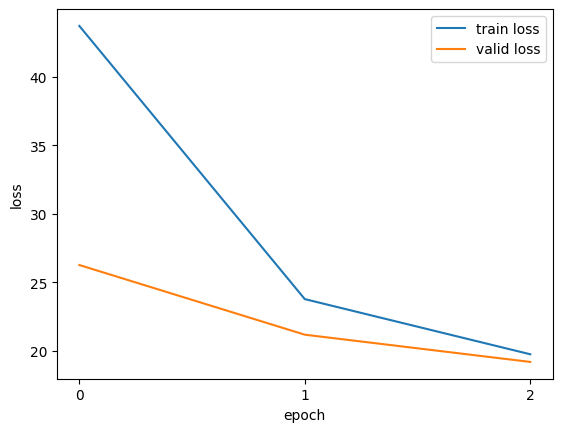

In [10]:
from spektral.data import BatchLoader
from utils.model import sync


loader_train = BatchLoader(train_data_total, batch_size=batch_size, shuffle=True)
loader_valid = BatchLoader(valid_data_total, batch_size=batch_size, shuffle=True)

best_epoch = 0
best_val_score = 1e10

# train model
loss_all = []
val_loss_all = []
start = time.time()
logging.info('----------------model total train start------------------')
for epoch in range(epochs):
	history = model_total.fit(loader_train.load(),
														validation_data=loader_valid.load(),
														steps_per_epoch=loader_train.steps_per_epoch,
														validation_steps=loader_valid.steps_per_epoch,
														epochs=1,
														shuffle=False)
	loss_all.append(history.history['loss'][0])
	val_loss_all.append(history.history['val_loss'][0])

	# log
	logging.info(f'total model:{model_name} epoch:{epoch} loss:{loss_all[-1]} val_loss:{val_loss_all[-1]}')

	# save model every model_save_freq epochs
	if (epoch + 1) % model_save_freq == 0:
		model_total_save_path = os.path.join(dir_parmas, f'{model_name}_total_lr{lr}_batchsize{batch_size}_epochs{epoch}.h5')
		model_total.save_weights(model_total_save_path)

	# save best model on validation set
	val_loss, val_score = model_total.evaluate(loader_valid.load(), steps=loader_valid.steps_per_epoch)
	if val_score < best_val_score:
		best_epoch = epoch
		best_val_score = val_score
		sync(model_total, model_best_total)
end = time.time()
logging.info(f'model total train done epoch: {epochs}, time: {end - start}s')
logging.info('-----------------model total train end-------------------')

# save best model
model_total_save_path = os.path.join(dir_parmas, f'{model_name}_total_best_lr{lr}_batchsize{batch_size}_epochs{best_epoch}of{epochs}.h5')
model_best_total.save_weights(model_total_save_path)
model_total.summary()

# plot 
plt.plot(loss_all, label='train loss')
plt.plot(val_loss_all, label='valid loss')
plt.legend()
plt.xticks(range(epochs))
plt.xlabel('epoch')
plt.ylabel('loss')

# save picture
plt_save_path = os.path.join(os.getcwd(), f"../results/{model_name}_total_lr{lr}_batchsize{batch_size}_epochs{epochs}.jpg")
plt.savefig(plt_save_path)

#### 模型测试

In [11]:
from utils.analysis import gnn_analysis


yt_train = np.array([data.y for data in train_data_total]).reshape(-1, 1)
yt_valid = np.array([data.y for data in valid_data_total]).reshape(-1, 1)
yt_test = np.array([data.y for data in test_data_total]).reshape(-1, 1)
dict_total = gnn_analysis(model_total, batch_size, 
						  train_data_total, yt_train,
						  valid_data_total, yt_valid,
						  test_data_total, yt_test, name=model_name)
results_total = pd.Series(dict_total).to_frame(name='total').T

# save results
dir_results = os.path.abspath(os.path.join(os.getcwd(), "../results/"))
if not os.path.exists(dir_results):
		os.mkdir(dir_results)

results_total.to_csv(os.path.join(dir_results, f"{model_name}_total_lr{lr}_batchsize{batch_size}_epochs{epochs}.csv"), index=False)

8/8 [==============================] - 0s 4ms/step
gcn train mse: 51.62374
gcn train r2: -1165.2974827754333
gcn valid mse: 54.802147
gcn valid r2: -1049.812757442552
gcn test mse: 49.108032
gcn test r2: -1099.2709571424268


gcn train analysis
min error: 0.24300125
max error: 0.5178613
mean error: 0.39837036
std error: 0.073282026
good ratio: 0.0
bad ratio: 1.0

gcn valid analysis
min error: 0.25089994
max error: 0.5127687
mean error: 0.4116933
std error: 0.071932994
good ratio: 0.0
bad ratio: 1.0

gcn test analysis
min error: 0.2518054
max error: 0.5172567
mean error: 0.38762325
std error: 0.07869943
good ratio: 0.0
bad ratio: 1.0



### 耦合电容模型

#### 模型训练

2025-04-04 13:54:43 335966104.py [line:15] INFO ----------------model couple train start------------------
d:\learn_more_from_life\computer\EDA\work\prj\rc_predict\code\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


23/23 [==============================] - 3s 37ms/step - loss: 2253.2544 - measure_ratio_good: 0.0000e+00 - val_loss: 501.0859 - val_measure_ratio_good: 0.0000e+00


2025-04-04 13:54:47 335966104.py [line:27] INFO couple model:gcn epoch:0 loss:2253.25439453125 val_loss:501.0859375


23/23 [==============================] - 0s 18ms/step - loss: 304.5086 - measure_ratio_good: 0.0000e+00 - val_loss: 156.6239 - val_measure_ratio_good: 0.0000e+00


2025-04-04 13:54:47 335966104.py [line:27] INFO couple model:gcn epoch:1 loss:304.50860595703125 val_loss:156.62388610839844


23/23 [==============================] - 0s 18ms/step - loss: 104.0793 - measure_ratio_good: 0.0000e+00 - val_loss: 62.8945 - val_measure_ratio_good: 0.0000e+00


2025-04-04 13:54:48 335966104.py [line:27] INFO couple model:gcn epoch:2 loss:104.07930755615234 val_loss:62.89445877075195


8/8 [==============================] - 0s 5ms/step - loss: 62.9172 - measure_ratio_good: 0.0000e+00


2025-04-04 13:54:48 335966104.py [line:41] INFO model couple train done epoch: 3, time: 4.637834072113037s
2025-04-04 13:54:48 335966104.py [line:42] INFO -----------------model couple train end-------------------


Model: "gcn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gcn_conv_3 (GCNConv)        multiple                  96        
                                                                 
 diff_pool_2 (DiffPool)      multiple                  4352      
                                                                 
 gcn_conv_4 (GCNConv)        multiple                  272       
                                                                 
 diff_pool_3 (DiffPool)      multiple                  1280      
                                                                 
 gcn_conv_5 (GCNConv)        multiple                  272       
                                                                 
 global_avg_pool_1 (GlobalAv  multiple                 0         
 gPool)                                                          
                                                             

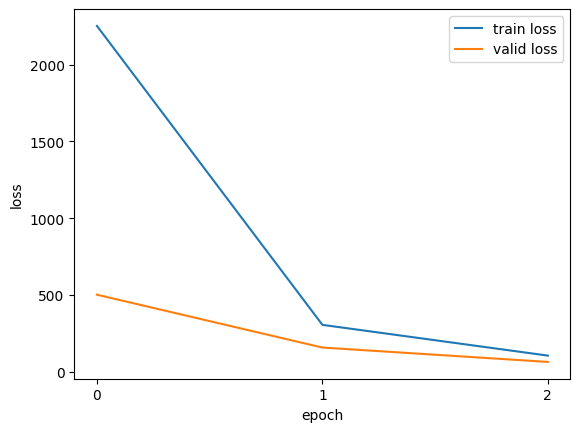

In [12]:
from spektral.data import BatchLoader
from utils.model import sync


loader_train = BatchLoader(train_data_couple, batch_size=batch_size, shuffle=True)
loader_valid = BatchLoader(valid_data_couple, batch_size=batch_size, shuffle=True)

best_epoch = 0
best_val_score = 1e10

# train model
loss_all = []
val_loss_all = []
start = time.time()
logging.info('----------------model couple train start------------------')
for epoch in range(epochs):
	history = model_couple.fit(loader_train.load(),
														validation_data=loader_valid.load(),
														steps_per_epoch=loader_train.steps_per_epoch,
														validation_steps=loader_valid.steps_per_epoch,
														epochs=1,
														shuffle=False)
	loss_all.append(history.history['loss'][0])
	val_loss_all.append(history.history['val_loss'][0])

	# log
	logging.info(f'couple model:{model_name} epoch:{epoch} loss:{loss_all[-1]} val_loss:{val_loss_all[-1]}')

	# save model every model_save_freq epochs
	if (epoch + 1) % model_save_freq == 0:
		model_couple_save_path = os.path.join(dir_parmas, f'{model_name}_couple_lr{lr}_batchsize{batch_size}_epochs{epoch}.h5')
		model_couple.save_weights(model_couple_save_path)

	# save best model on validation set
	val_loss, val_score = model_couple.evaluate(loader_valid.load(), steps=loader_valid.steps_per_epoch)
	if val_score < best_val_score:
		best_epoch = epoch
		best_val_score = val_score
		sync(model_couple, model_best_couple)
end = time.time()
logging.info(f'model couple train done epoch: {epochs}, time: {end - start}s')
logging.info('-----------------model couple train end-------------------')

# save best model
model_couple_save_path = os.path.join(dir_parmas, f'{model_name}_couple_best_lr{lr}_batchsize{batch_size}_epochs{best_epoch}of{epochs}.h5')
model_best_couple.save_weights(model_couple_save_path)
model_couple.summary()

# plot 
plt.plot(loss_all, label='train loss')
plt.plot(val_loss_all, label='valid loss')
plt.legend()
plt.xticks(range(epochs))
plt.xlabel('epoch')
plt.ylabel('loss')

# save picture
plt_save_path = os.path.join(os.getcwd(), f"../results/{model_name}_couple_lr{lr}_batchsize{batch_size}_epochs{epochs}.jpg")
plt.savefig(plt_save_path)

#### 模型测试

In [13]:
from utils.analysis import gnn_analysis


yc_train = np.array([data.y for data in train_data_couple]).reshape(-1, 1)
yc_valid = np.array([data.y for data in valid_data_couple]).reshape(-1, 1)
yc_test = np.array([data.y for data in test_data_couple]).reshape(-1, 1)
dict_couple = gnn_analysis(model_couple, batch_size, 
						   train_data_couple, yc_train, 
						   valid_data_couple, yc_valid,
						   test_data_couple, yc_test, name=model_name)
results_couple = pd.Series(dict_couple).to_frame(name='couple').T

# save results
dir_results = os.path.abspath(os.path.join(os.getcwd(), "../results/"))
if not os.path.exists(dir_results):
	os.mkdir(dir_results)

results_couple.to_csv(os.path.join(dir_results, f"{model_name}_couple_lr{lr}_batchsize{batch_size}_epochs{epochs}.csv"), index=False)

8/8 [==============================] - 0s 5ms/step
gcn train mse: 24.942371
gcn train r2: -1364.1801279526635
gcn valid mse: 24.440332
gcn valid r2: -1166.681407514343
gcn test mse: 22.151869
gcn test r2: -1110.2377893113546


gcn train analysis
min error: 5.433421
max error: 25.139135
mean error: 9.245713
std error: 3.5597644
good ratio: 0.0
bad ratio: 1.0

gcn valid analysis
min error: 5.13377
max error: 20.481071
mean error: 9.331168
std error: 3.3756874
good ratio: 0.0
bad ratio: 1.0

gcn test analysis
min error: 5.651741
max error: 16.18092
mean error: 8.655517
std error: 2.3667102
good ratio: 0.0
bad ratio: 1.0

